# 블로그 설명

해당 자료에 대한 설명은 아래 블로그에도 올려두었습니다.
- https://lsjsj92.tistory.com/569

---- 

# 추천 시스템 - 협업 필터링 Matrix Factorization

이번 글은 추천 시스템의 협업 필터링 중에서 행렬 분해(Matrix Factorization)에 대해서 작성합니다.  
해당 자료는 아래에서 참고했습니다.

- https://github.com/SurhanZahid/Recommendation-System-Using-Matrix-Factorization/blob/master/Recommender%20System%20With%20Matrix%20Factorization%20.ipynb
- https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

데이터는 kaggle의 https://www.kaggle.com/sengzhaotoo/movielens-small 이 데이터입니다.

In [44]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [45]:
rating_data = pd.read_csv('ratings.csv')
movie_data = pd.read_csv('movies.csv')

In [46]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [47]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [48]:
print(movie_data.shape)
print(rating_data.shape)

(27278, 3)
(1048575, 4)


두 개의 파일은 사용자-평점 데이터와 영화 데이터로 나뉘어져 있습니다.   

이 두개의 파일은 공통적으로 movieId를 가지고 있습니다. 즉, movieId를 이용하면 하나로 합칠 수 있습니다.  


# 전처리 

In [49]:
rating_data.drop('timestamp', axis = 1, inplace = True)
rating_data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [50]:
movie_data.drop('genres', axis = 1, inplace = True)
movie_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [51]:
user_movie_data = pd.merge(rating_data, movie_data, on = 'movieId')
user_movie_data.head()

,userId,movieId,rating,title
0,1,2,3.5,Jumanji (1995)
1,5,2,3.0,Jumanji (1995)
2,13,2,3.0,Jumanji (1995)
3,29,2,3.0,Jumanji (1995)
4,34,2,3.0,Jumanji (1995)


In [52]:
user_movie_data.shape

(1048575, 4)

불필요한 컬럼을 제거한 뒤 pandas의 merge를 이용해서 하나로 합쳤습니다.   

이제, pivot_table을 만들어줍니다.   

value에는 rating값을, column에는 movie title 값을, index는 user id를 넣어줍니다.

In [53]:
user_movie_rating = user_movie_data.pivot_table('rating', index = 'userId', columns='title').fillna(0)

In [54]:
user_movie_rating.shape

(7120, 14021)

In [55]:
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",$5 a Day (2008),'71 (2014),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'R Xmas (2001),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nos amours (1983),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


자! 이제 사용자-영화 데이터의 pivot table을 만들었습니다.  

이제 사용자-영화 기준의 데이터를 **영화-사용자** 기준으로 만들어서 특정 '영화'와 비슷한 영화를 추천해주는 로직을 구현해봅니다.


In [56]:
movie_user_rating = user_movie_rating.values.T
movie_user_rating.shape

(14021, 7120)

In [57]:
type(movie_user_rating)

numpy.ndarray

여기서 이제 SVD를 사용합니다.   

**SVD(Singular Value Decomposion), 특이값 분해**란 m x n 크기의 데이터 행렬 A를 아래와 같이 분해하는 것을 말합니다.

![15](https://user-images.githubusercontent.com/24634054/73115129-93138c00-3f65-11ea-9a10-80abc59a8494.JPG)


출처 : https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/06/pcasvdlsa/

행렬 U와 V에 속한 열벡터는 특이벡터(singular vector)로 불리고, 이 특이벡터들은 서로 직교하는 성질을 가지고 있습니다.
또한, 가운데 시그마 기호로 보이는 것은 이것도 행렬인데요. 이 행렬은 대각행렬(diagonal matrix) 성질을 가지고 있습니다. 그래서 대각 성분이 행렬 A의 특이값이고 나머지 성분이 0입니다.


그리고 사이킷런에서 제공해주는 truncated SVD는 이러한 SVD의 변형입니다.
**truncated SVD**는 시그마 행렬의 대각원소(특이값) 가운데 상위 n개만 골라낸 것입니다. 이렇게 하면 기존 행렬 A의 성질을 100% 원복할 수는 없지만, (그 만큼 데이터 정보를 압축) 행렬 A와 거의 근사한 값이 나오게 됩니다.



여기서는 scikit learn의 TruncatedSVD를 사용해봅니다.

In [58]:
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(14021, 12)

In [59]:
matrix[0]

array([ 0.04351815, -0.04828713,  0.00955942, -0.02306223, -0.01899073,
        0.10234525, -0.0663631 ,  0.01877643,  0.00260006, -0.02884459,
        0.04659381,  0.08930732])

12개의 component로 차원을 축소했습니다. 

이제 이렇게 나온 데이터를 활용해서 피어슨 상관계수를 구합니다.

In [60]:
corr = np.corrcoef(matrix)
corr.shape

(14021, 14021)

In [61]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

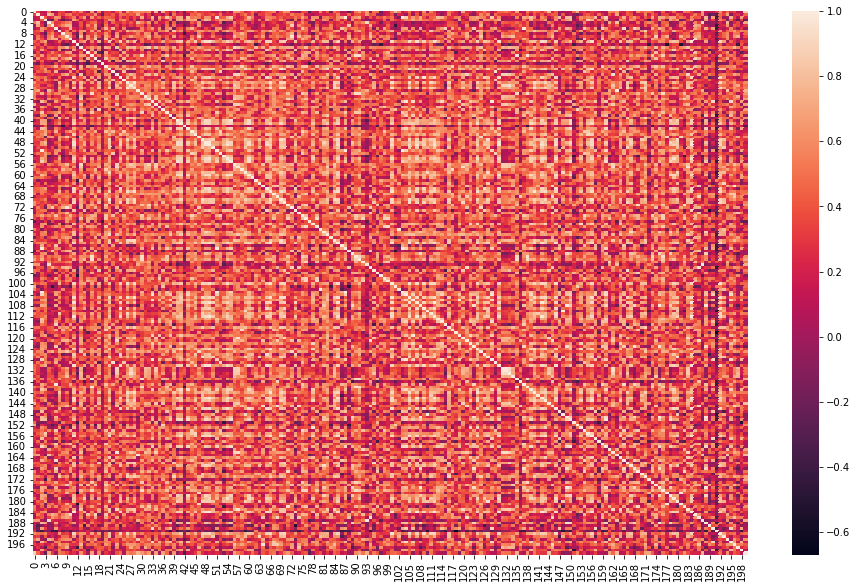

In [62]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

이렇게 나온 상관계수를 이용해서 특정 영화와 상관계수가 높은 영화를 뽑아줍니다.

In [63]:
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Guardians of the Galaxy (2014)")

In [64]:
corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])[:50]

['(500) Days of Summer (2009)',
 '10 Years (2011)',
 '12 Years a Slave (2013)',
 '127 Hours (2010)',
 '13 Assassins (Jûsan-nin no shikaku) (2010)',
 '14 Blades (Jin yi wei) (2010)',
 '2012 (2009)',
 '21 (2008)',
 '21 Jump Street (2012)',
 '21 and Over (2013)',
 '22 Jump Street (2014)',
 '3 Idiots (2009)',
 '30 Minutes or Less (2011)',
 '300: Rise of an Empire (2014)',
 '5 Centimeters per Second (Byôsoku 5 senchimêtoru) (2007)',
 '50/50 (2011)',
 '6 Souls (Shelter) (2010)',
 '9 (2009)',
 '9th Company (2005)',
 'A-Team, The (2010)',
 'About Cherry (2012)',
 'About Time (2013)',
 'Adam (2009)',
 'Adjustment Bureau, The (2011)',
 'Adventurer: The Curse of the Midas Box, The (2013)',
 'Adventures of Tintin, The (2011)',
 'Afro Samurai: Resurrection (2009)',
 'Agora (2009)',
 'Alice in Wonderland (2010)',
 'Amazing Spider-Man, The (2012)',
 'American Hustle (2013)',
 'American Sniper (2014)',
 'American, The (2010)',
 'Anamorph (2007)',
 'Angel-A (2005)',
 'Angels & Demons (2009)',
 "Angels'

**마블의 가디언즈 오브 갤럭시** 영화를 기준으로 비슷한 영화를 뽑아봤습니다.   
10000BC, 엔트맨, 어벤저스 영화 등이 보이는 것을 알 수 있습니다.

# 한 사용자에게 개인 추천을 해주기

위에서는 하나의 영화에 대해서 비슷한 영화를 추천해주는 것을 적용했습니다.   
하지만, 보통 추천 시스템은 사용자에게 추천을 해주어야 합니다.  

사용자에게 추천을 해주기 위해서 사용자 맞춤 협업 필터링 행렬 분해를 적용해보겠습니다.

In [65]:
df_ratings  = pd.read_csv('ratings.csv')
df_movies  = pd.read_csv('movies.csv')

In [66]:
df_user_movie_ratings = df_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [67]:
df_user_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129350,129354,129428,129707,130052,130073,130219,130462,130490,130642
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


여기까지는 앞서 했던 것과 똑같습니다. 사용자-영화 pivot table을 만드는 것이죠.   

이제 아래와 같이 데이터를 조금 변경해서 진행하겠습니다.

1. pivot table을 matrix로 변환
2. np.mean(axis = 1)을 통해 각 사용자들이 매기는 평점 평균을 구함
3. 1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [68]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것 
matrix = df_user_movie_ratings.values

# user_ratings_mean은 사용자의 평균 평점 
user_ratings_mean = np.mean(matrix, axis = 1)

# R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [69]:
matrix

array([[0. , 3.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 4. , ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ],
       [4.5, 4. , 0. , ..., 0. , 0. , 0. ]])

In [70]:
matrix.shape

(7120, 14026)

In [71]:
user_ratings_mean.shape

(7120,)

In [72]:
matrix_user_mean.shape

(7120, 14026)

In [73]:
pd.DataFrame(matrix_user_mean, columns = df_user_movie_ratings.columns).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129350,129354,129428,129707,130052,130073,130219,130462,130490,130642
0,-0.046699,3.453301,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,...,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699,-0.046699
1,-0.017396,-0.017396,3.982604,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,...,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396,-0.017396
2,3.945031,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,...,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969,-0.054969
3,-0.007130,-0.007130,-0.007130,-0.007130,-0.007130,2.992870,-0.007130,-0.007130,-0.007130,3.992870,...,-0.007130,-0.007130,-0.007130,-0.007130,-0.007130,-0.007130,-0.007130,-0.007130,-0.007130,-0.007130
4,-0.020106,2.979894,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,...,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106,-0.020106


여기까지 진행하면 초기에 만들었던 user-movie pivot table 값이 matrix_user_mean 변경되었습니다.

즉, 아래와 같이 변경된 것이죠.

1. 사용자 671명이 9066개의 영화에 대해 평점을 매긴 값이 존재
2. 사용자 671명의 각각 평균 평점을 구해서
3. 사용자 671명의 9066개의 영화에 대해 평점을 조금 변경 -> 1에서 구한 값 - 2에서 구한 값


**이제 SVD를 이용해 Matrix Factorization**을 진행해봅니다. 

앞서서는 scikit learn을 이용해 TruncatedSVD를 이용했는데요. 이번에는 scipy를 이용해 Truncated SVD를 구해봅니다.

이 둘의 차이점은 scikit learn에서 제공해주는 TruncatedSVD는 U, Sigma, Vt 반환 값을 제공하지 않습니다.   
하지만, Scipy를 이용하면 이 반환값들을 제공받을 수 있죠.

Scipy에서 제공해주는 Truncate SVD는 scipy.sparse.linalg.svds를 이용하면 됩니다. 저는 이것을 이용했습니다.

이렇게 사용하면 반환값이 U 행렬, Sigma 행렬, V 전치 행렬(Vt)가 나오게 됩니다.

In [74]:
# scipy에서 제공해주는 svd.  
# U 행렬, sigma 행렬, V 전치 행렬을 반환.

U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [75]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(7120, 12)
(12,)
(12, 14026)


현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태입니다.  
**즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 합니다.**

In [76]:
sigma = np.diag(sigma)

In [77]:
sigma.shape

(12, 12)

In [78]:
sigma[0]

array([269.83492458,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [79]:
sigma[1]

array([  0.        , 282.15738686,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

이렇게 대칭 행렬로 변환이 되었습니다.   

현재 까지 상황을 정리하면 아래와 같습니다.   

1. 원본 user-movie 평점 행렬이 있었음
2. 이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
3. 2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
4. Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환


자! 이제 여기서 matrix_user_mean을 SVD를 적용해 분해를 한 상태입니다.  
이제, 다시 원본 행렬로 복구시켜야겠죠?

원본 행렬로 복구시키는 방법은 아래와 같습니다.

- U, Sigma, Vt의 내적을 수행 

즉, np.dot(np.dot(U, sigma), Vt)를 수행하면 됩니다. 

그리고 아까 사용자 평균을 빼주었으니 여기서는 더해줍니다. 


In [80]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다. 
# 거기에 + 사용자 평균 rating을 적용한다. 
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [81]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_movie_ratings.columns)
df_svd_preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129350,129354,129428,129707,130052,130073,130219,130462,130490,130642
0,1.584248,0.729275,-0.163974,-0.074303,-0.265739,0.254593,-0.507863,0.030033,-0.063498,0.764585,...,0.006690,-0.000412,-0.006516,0.004385,0.005273,0.002410,-0.002721,0.006462,0.000848,0.007240
1,0.964815,0.232550,0.122438,-0.005260,0.062747,0.556692,0.213116,0.012683,0.090096,0.415650,...,0.008051,0.008333,0.005630,0.007703,0.007490,0.007053,0.008868,0.007602,0.005743,0.007219
2,2.298634,0.517306,0.001056,-0.031406,-0.267162,1.140612,-0.055695,0.018382,0.056020,0.904963,...,0.003475,-0.000151,-0.010449,-0.000928,-0.000572,-0.001379,-0.001929,0.002020,-0.006674,0.000495
3,0.524719,0.544708,0.270496,0.047304,0.267203,0.496928,0.194208,0.045729,0.120319,0.986486,...,-0.000626,0.000422,-0.000127,-0.000008,-0.000182,0.000064,0.000793,0.000199,-0.001612,-0.000517
4,3.272550,1.299401,1.179901,0.170556,1.098823,1.360032,1.318102,0.146293,0.393685,1.680312,...,0.007529,0.007902,0.010041,0.006811,0.005459,0.006187,0.008200,0.007660,0.005388,0.002975


In [82]:
df_svd_preds.shape

(7120, 14026)

자! 이제 함수를 하나 만듭니다. 이 함수의 기능은 아래와 같습니다.

- 인자로 사용자 아이디, 영화 정보 테이블, 평점 테이블 등을 받음
- 사용자 아이디에 SVD로 나온 결과의 영화 평점이 가장 높은 데이터 순으로 정렬
- 사용자가 본 데이터를 제외
- 사용자가 안 본 영화에서 평점이 높은 것을 추천

In [83]:
def recommend_movies(df_svd_preds, user_id, ori_movies_df, ori_ratings_df, num_recommendations=5):
    
    #현재는 index로 적용이 되어있으므로 user_id - 1을 해야함.
    user_row_number = user_id - 1 
    
    # 최종적으로 만든 pred_df에서 사용자 index에 따라 영화 데이터 정렬 -> 영화 평점이 높은 순으로 정렬 됌
    sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)
    
    # 원본 평점 데이터에서 user id에 해당하는 데이터를 뽑아낸다. 
    user_data = ori_ratings_df[ori_ratings_df.userId == user_id]
    
    # 위에서 뽑은 user_data와 원본 영화 데이터를 합친다. 
    user_history = user_data.merge(ori_movies_df, on = 'movieId').sort_values(['rating'], ascending=False)
    
    # 원본 영화 데이터에서 사용자가 본 영화 데이터를 제외한 데이터를 추출
    recommendations = ori_movies_df[~ori_movies_df['movieId'].isin(user_history['movieId'])]
    # 사용자의 영화 평점이 높은 순으로 정렬된 데이터와 위 recommendations을 합친다. 
    recommendations = recommendations.merge( pd.DataFrame(sorted_user_predictions).reset_index(), on = 'movieId')
    # 컬럼 이름 바꾸고 정렬해서 return
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      

    return user_history, recommendations

In [84]:
already_rated, predictions = recommend_movies(df_svd_preds, 330, df_movies, df_ratings, 10)

In [85]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
11,330,17,5.0,832527100,Sense and Sensibility (1995),Drama|Romance
28,330,47,5.0,832316534,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
30,330,50,5.0,832316582,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
200,330,588,5.0,832316387,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
154,330,349,5.0,832316387,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
190,330,509,5.0,832527559,"Piano, The (1993)",Drama|Romance
44,330,110,5.0,832316498,Braveheart (1995),Action|Drama|War
131,330,296,5.0,832316356,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
0,330,1,4.0,832316434,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
183,330,457,4.0,832527196,"Fugitive, The (1993)",Thriller


In [86]:
predictions

,movieId,title,genres,Predictions
188,356,Forrest Gump (1994),Comedy|Drama|Romance|War,3.845718
204,377,Speed (1994),Action|Romance|Thriller,3.512418
283,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.479120
301,500,Mrs. Doubtfire (1993),Comedy|Drama,3.364050
375,587,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller,3.283805
380,597,Pretty Woman (1990),Comedy|Romance,3.123346
325,527,Schindler's List (1993),Drama|War,3.097972
189,357,Four Weddings and a Funeral (1994),Comedy|Romance,3.069377
336,539,Sleepless in Seattle (1993),Comedy|Drama|Romance,3.032854
376,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,2.902151


이렇게 추천을 할 수 있습니다.